
# STOCK MARKET ANALYSIS
# Companies: TCS, Wipro, Infosys, Capgemini
# Tools: Python, yFinance, Pandas, Matplotlib



 INSTALL DEPENDENCIES


In [1]:
!pip install yfinance pandas matplotlib python-dateutil --quiet
# yfinance  → used to get stock data from Yahoo Finance
# pandas    → used to work with data tables
# matplotlib → used to make charts and graphs
# python-dateutil → helps work with dates and times easily


#### IMPORT CORE LIBRARIES


In [2]:
import os                      # Used for working with files and folders
import time                    # Used to add delays (pause code for a few seconds)
from datetime import datetime, timezone   # Used to get the current date and time
from dateutil.relativedelta import relativedelta  # Helps to find dates like "10 years ago"

import pandas as pd            # Used for handling and analyzing data (tables)
import matplotlib.pyplot as plt # Used for creating charts and graphs
import yfinance as yf          # Used to download stock data from Yahoo Finance

# This command makes charts show directly inside Jupyter Notebook
%matplotlib inline



#### DEFINE COMPANY TICKERS


In [3]:
# Dictionary that stores company names and their stock symbols (tickers)
# .NS → means the company is listed on the NSE (National Stock Exchange of India)
# .PA → means the company is listed on the Paris Stock Exchange

TICKER_MAP = {
    "TCS": "TCS.NS",         # Tata Consultancy Services (India)
    "WIPRO": "WIPRO.NS",     # Wipro Limited (India)
    "INFOSYS": "INFY.NS",    # Infosys Limited (India)
    "CAPGEMINI": "CAP.PA"    # Capgemini SE (France)
}



#### DEFINE VISUALIZATION COLORS


In [4]:
# Dictionary that gives each company a color for charts
# These colors help tell the companies apart in visualizations

COMPANY_COLORS = {
    "TCS": "#D4AF37",      # Gold color for TCS
    "WIPRO": "#1f77b4",    # Blue color for Wipro
    "INFOSYS": "#d62728",  # Red color for Infosys
    "CAPGEMINI": "#ff7f0e" # Orange color for Capgemini
}



#### DEFINE DATE RANGE (10 YEARS)


In [5]:
# Get today's date and time (in UTC format – Universal Time)
TODAY = datetime.now(timezone.utc)

# Find the date exactly 10 years before today
TEN_YEARS_AGO = TODAY - relativedelta(years=10)

# Print the time range we will use to download stock data
print(f"Data Range: {TEN_YEARS_AGO.date()} → {TODAY.date()}")

Data Range: 2015-11-03 → 2025-11-03



#### SETUP WORKING DIRECTORIES


In [6]:
# Create directories for storing data and plots
os.makedirs("data_csv", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Confirmation message
print("✅ Directories created successfully: data_csv/, plots/")

✅ Directories created successfully: data_csv/, plots/



#### HELPER FUNCTIONS — PART 1


In [7]:
def download_single_ticker_history(ticker: str, start_dt: datetime, end_dt: datetime) -> pd.DataFrame:
    """
    Download 10-year stock data from Yahoo Finance.
    Returns a cleaned DataFrame with datetime index.
    """
    t = yf.Ticker(ticker)

    # End date should be exclusive
    end_exclusive = (end_dt).date() + pd.Timedelta(days=1)

    df = t.history(
        start=start_dt.strftime("%Y-%m-%d"),
        end=end_exclusive.strftime("%Y-%m-%d"),
        interval="1d",
        auto_adjust=False,
        actions=False
    )

    # Validate data
    if df is None or df.empty:
        raise RuntimeError(f"No data returned for {ticker}")

    # Clean index timezone
    df.index = pd.to_datetime(df.index).tz_localize(None)
    return df


#### HELPER FUNCTIONS — PART 2


In [8]:
def ensure_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ensure numeric columns exist and have valid values.
    Adds 'Adj Close' if missing and coerces numeric types.
    """
    # If 'Adj Close' column is not present, create it using 'Close' values
    if "Adj Close" not in df.columns:
        df["Adj Close"] = df["Close"]

    # Convert important columns to numeric type (in case they are strings)
    for col in ["Open", "High", "Low", "Close", "Adj Close", "Volume"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Remove rows that have missing (NaN) 'Close' values
    return df.dropna(subset=["Close"])

#### DATA COLLECTION


In [9]:
data_summary = []   # List to store summary info for each company
data_dict = {}      # Dictionary to store all downloaded DataFrames

# Loop through all companies in TICKER_MAP
for name, ticker in TICKER_MAP.items():
    print(f"Downloading data for {name} ({ticker})...")

    # Download 10-year data for this company
    df = download_single_ticker_history(ticker, TEN_YEARS_AGO, TODAY)

    # Clean and check all important columns
    df = ensure_columns(df)

    # Save the data as a CSV file inside 'data_csv' folder
    csv_path = f"data_csv/{name}_daily_raw.csv"
    df.to_csv(csv_path, index=True)
    print(f"-> Saved raw CSV: {csv_path} (rows: {len(df)})")

    # Store the cleaned DataFrame in a dictionary for later analysis
    data_dict[name] = df

    # Save summary information about this company’s data
    data_summary.append([
        name,                   # Company name
        len(df),                # Number of rows (days of data)
        len(df.columns),        # Number of columns
        df.index.min().date(),  # Start date
        df.index.max().date(),  # End date
        df.isna().sum().sum()   # Total missing values
    ])

    time.sleep(1)  # Wait for 1 second to prevent API overload

-> Saved raw CSV: data_csv/TCS_daily_raw.csv (rows: 2469)
-> Saved raw CSV: data_csv/WIPRO_daily_raw.csv (rows: 2469)
-> Saved raw CSV: data_csv/INFOSYS_daily_raw.csv (rows: 2469)
-> Saved raw CSV: data_csv/CAPGEMINI_daily_raw.csv (rows: 2561)



#### DATA SUMMARY & INSPECTION


In [10]:
# Create a DataFrame from the collected summary list
summary_df = pd.DataFrame(
    data_summary,
    columns=["Company", "Rows", "Columns", "Start", "End", "MissingValues"]
)

# Print a clear message before showing the summary
print("\n Download complete. Data Summary:\n")

# Display the summary table
print(summary_df)


 Download complete. Data Summary:

     Company  Rows  Columns       Start         End  MissingValues
0        TCS  2469        6  2015-11-03  2025-11-03              0
1      WIPRO  2469        6  2015-11-03  2025-11-03              0
2    INFOSYS  2469        6  2015-11-03  2025-11-03              0
3  CAPGEMINI  2561        6  2015-11-03  2025-10-31              0



#### MONTHLY & YEARLY RESAMPLING


In [11]:
# Create an empty dictionary to store resampled data
resampled_data = {}

# Go through each company's data
for name, df in data_dict.items():

    # --- Monthly Data ---
    # Find the highest stock price each month
    monthly_high = df["High"].resample("ME").max()

    # Find the lowest stock price each month
    monthly_low = df["Low"].resample("ME").min()

    # Get the last adjusted close price of each month
    monthly_adj_close = df["Adj Close"].resample("ME").last()

    # --- Yearly Data ---
    # Add up total trading volume for each year
    yearly_volume = df["Volume"].resample("YE").sum()

    # --- Store all results in a dictionary for the company ---
    resampled_data[name] = {
        "monthly_high": monthly_high,
        "monthly_low": monthly_low,
        "monthly_adj_close": monthly_adj_close,
        "yearly_volume": yearly_volume
    }



#### RESAMPLING SUMMARY


In [12]:
# Print message to show resampling is finished
print("\n Resampling completed successfully for companies:")

# List each company that was processed
for company in resampled_data.keys():
    print(f" - {company}")

# Pick the first company from the dictionary for a quick preview
sample_name = list(resampled_data.keys())[0]

# Print first few rows of that company's monthly adjusted close data
print(f"\nSample Preview ({sample_name}):")
print(resampled_data[sample_name]["monthly_adj_close"].head())


 Resampling completed successfully for companies:
 - TCS
 - WIPRO
 - INFOSYS
 - CAPGEMINI

Sample Preview (TCS):
Date
2015-11-30     953.561951
2015-12-31     978.992249
2016-01-31     963.015747
2016-02-29     876.633301
2016-03-31    1014.966431
Freq: ME, Name: Adj Close, dtype: float64





#### UNIVARIATE ANALYSIS – VISUALIZATION


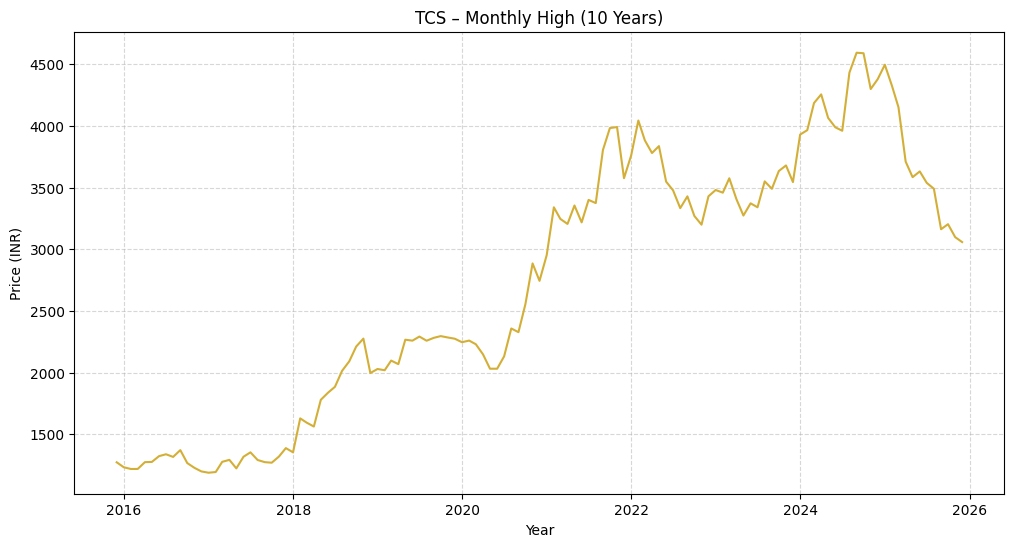

In [13]:
# Select the company name
name = "TCS"

# Get resampled (monthly/yearly) data for that company
df = resampled_data[name]

# --- Plot Monthly High Prices ---
plt.figure(figsize=(12, 6))  # Set figure size (width, height)
plt.plot(df["monthly_high"], color=COMPANY_COLORS[name])  # Line chart for monthly highs

# Add title and labels
plt.title("TCS – Monthly High (10 Years)")
plt.xlabel("Year")               # X-axis label
plt.ylabel("Price (INR)")        # Y-axis label

# Add grid lines for better readability
plt.grid(True, linestyle="--", alpha=0.5)

# Show the final chart
plt.show()

###  TCS – Monthly High (2015–2025)
TCS stock price showed steady growth from 2015 to 2025 with a big rise after 2020 during the tech boom.  
It reached its highest point around 2024 and then slightly dropped in 2025, showing a small market correction.

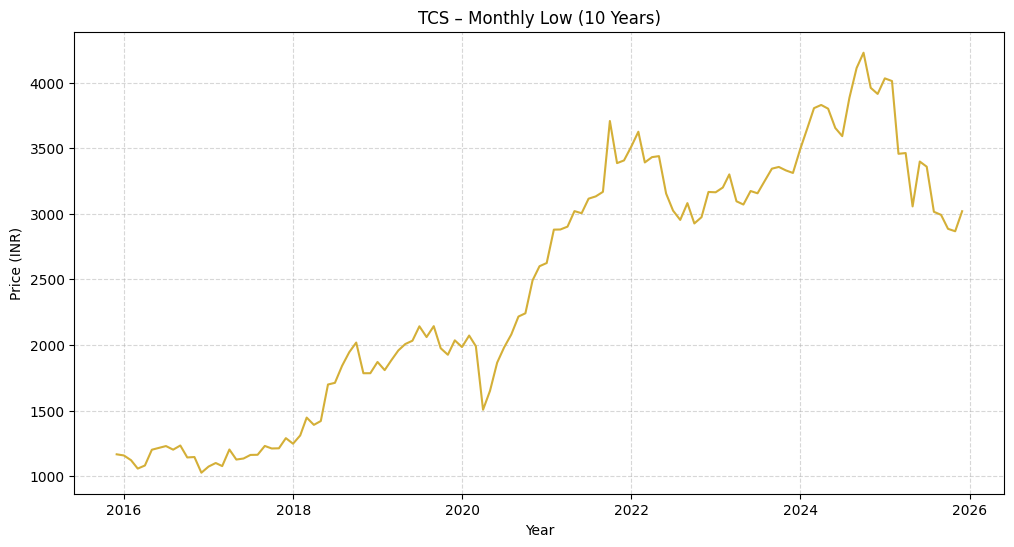

In [14]:
# --- Plot Monthly Low Prices ---
plt.figure(figsize=(12, 6))  # Set the chart size (width, height)

# Draw line plot for monthly low prices of TCS
plt.plot(df["monthly_low"], color=COMPANY_COLORS[name])

# Add chart title and labels
plt.title("TCS – Monthly Low (10 Years)")
plt.xlabel("Year")               # Label for X-axis (time)
plt.ylabel("Price (INR)")        # Label for Y-axis (price)

# Add grid lines to make the chart easier to read
plt.grid(True, linestyle="--", alpha=0.5)

# Display the chart
plt.show()

### TCS – Monthly Low (2015–2025)
The lowest prices of TCS also increased steadily over the years, showing long-term strength.  
Small drops can be seen around 2020 and 2025, likely due to market corrections or global events.


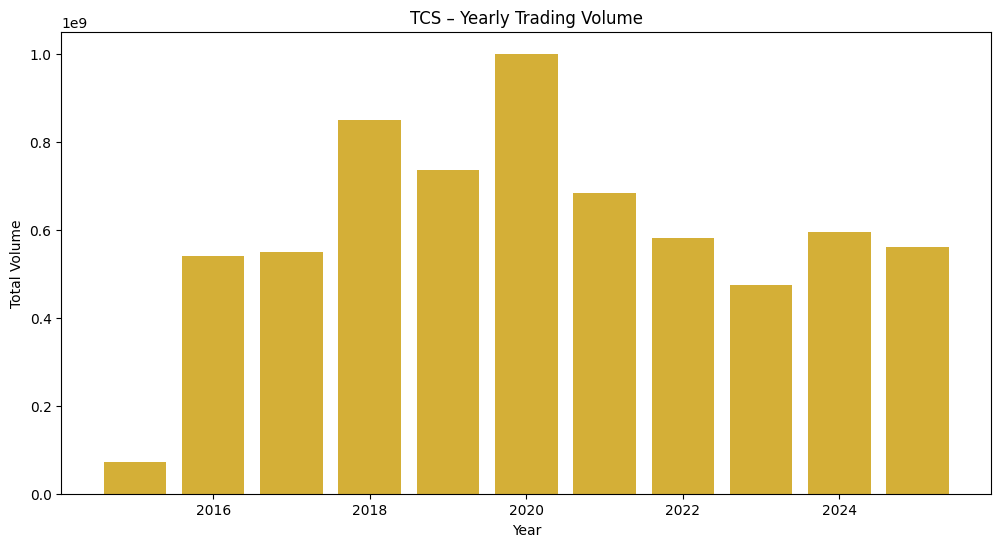

In [15]:
# --- Plot Yearly Trading Volume ---
plt.figure(figsize=(12, 6))  # Set chart size

# Get the year values from the index (like 2015, 2016, etc.)
years = [d.year for d in df["yearly_volume"].index]

# Create a bar chart showing total trading volume per year
plt.bar(years, df["yearly_volume"].values, color=COMPANY_COLORS[name])

# Add title and axis labels
plt.title("TCS – Yearly Trading Volume")
plt.xlabel("Year")              # X-axis shows the year
plt.ylabel("Total Volume")      # Y-axis shows total traded shares

# Show the final chart
plt.show()

### TCS – Yearly Trading Volume (2015–2025)
The trading volume of TCS was highest around 2020, showing strong investor activity.  
After 2020, the volume slightly decreased but remained steady, indicating continued market interest.


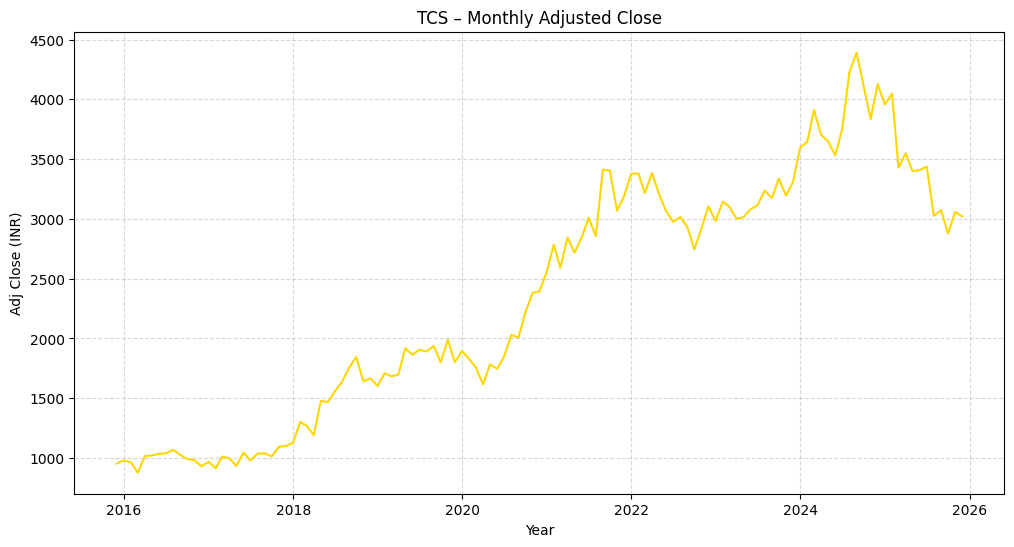

In [16]:
#  Plot Monthly Adjusted Close for TCS
plt.figure(figsize=(12,6))  # Set figure size
plt.plot(df["monthly_adj_close"], color='gold')  # Plot with gold color
plt.title("TCS – Monthly Adjusted Close")  # Add title
plt.xlabel("Year")  # Label for x-axis
plt.ylabel("Adj Close (INR)")  # Label for y-axis
plt.grid(True, linestyle="--", alpha=0.5)  # Add light dashed grid
plt.show()  # Display the plot


### TCS – Monthly Adjusted Close
TCS stock showed steady growth until 2021,  
reaching its peak in early 2022 before a major correction.  
Despite fluctuations, prices remain well above pre-2020 levels, showing long-term strength.


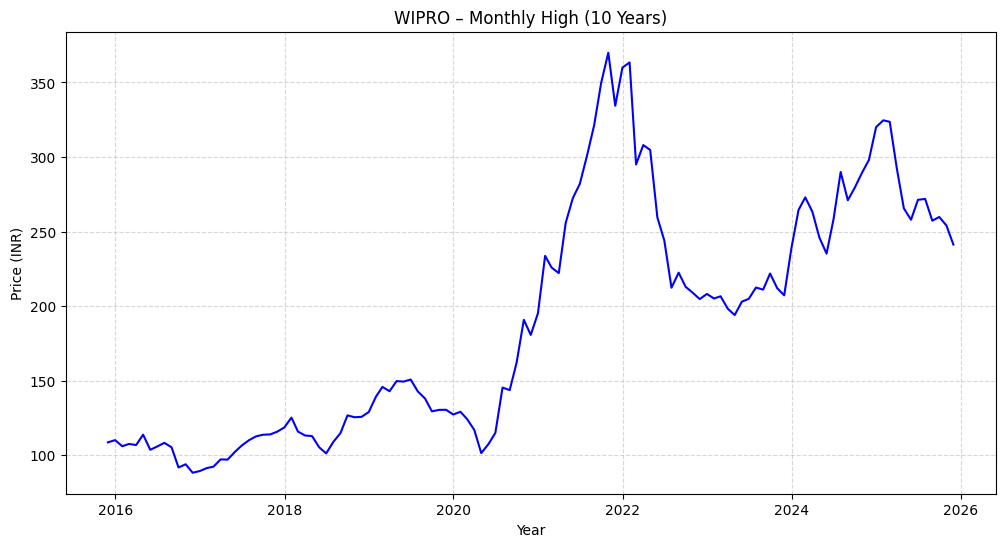

In [17]:
# --- Plot Monthly High Prices for WIPRO (10 Years) ---
name = "WIPRO"  # Select company name
df = resampled_data[name]  # Get the resampled data for WIPRO

plt.figure(figsize=(12, 6))  # Set the figure size (width x height)

# Plot the monthly high prices using blue color
plt.plot(df["monthly_high"], color='blue')

# Add title and axis labels
plt.title("WIPRO – Monthly High (10 Years)")  # Chart title
plt.xlabel("Year")                            # X-axis label (time in years)
plt.ylabel("Price (INR)")                     # Y-axis label (stock price)

# Add grid lines for better readability
plt.grid(True, linestyle="--", alpha=0.5)

# Show the final chart
plt.show()

### Wipro – Monthly High (10 Years)
Wipro’s stock hit its peak between 2021 and 2022,  
followed by a decline and partial recovery in 2024–2025.  
Despite volatility, prices are still much higher than pre-2020 levels.


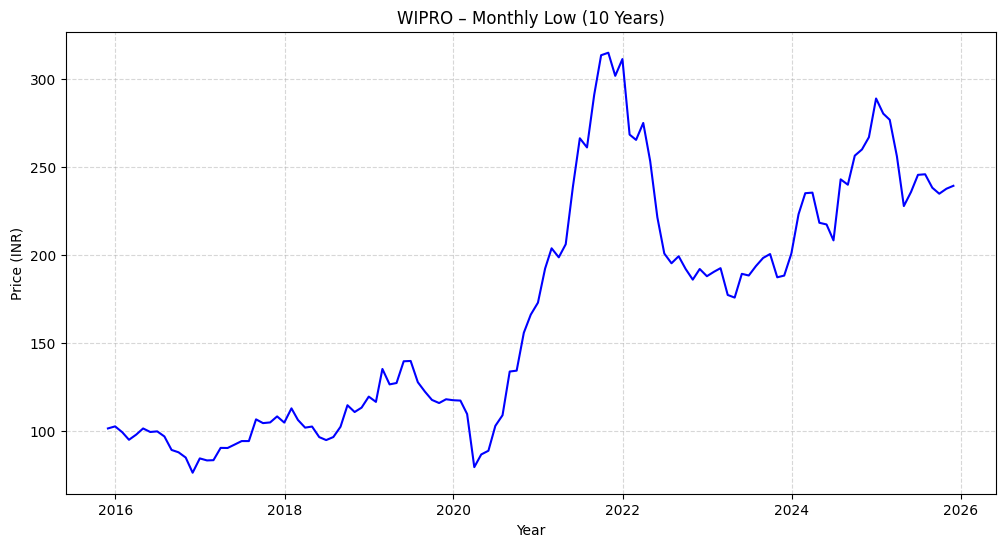

In [18]:
# --- Plot Monthly Low Prices for Wipro ---
plt.figure(figsize=(12, 6))  # Set chart size (width, height)

# Draw line plot showing the lowest price each month
plt.plot(df["monthly_low"], color="blue")  # Use blue color for the line

# Add title and labels for better understanding
plt.title("WIPRO – Monthly Low (10 Years)")  # Chart title
plt.xlabel("Year")                            # X-axis shows time (years)
plt.ylabel("Price (INR)")                     # Y-axis shows stock price in INR

# Add grid lines to make the trend easier to read
plt.grid(True, linestyle="--", alpha=0.5)

# Display the chart
plt.show()

### Wipro – Monthly Low (10 Years)
Wipro’s stock price grew steadily till 2021, reaching a high in 2024.  
After that, it showed slight decline but remained above 2016 levels.


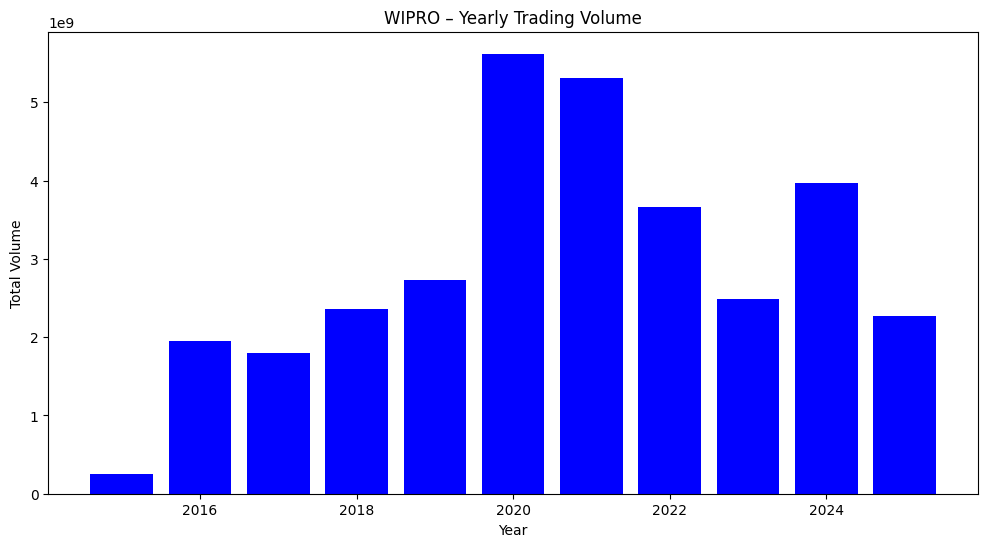

In [19]:
# --- Plot Yearly Trading Volume for Wipro ---
plt.figure(figsize=(12, 6))  # Set the figure size (width x height)

# Extract only the year part from the index (e.g., 2015, 2016, ...)
years = [d.year for d in df["yearly_volume"].index]

# Create a bar chart for yearly total trading volume
plt.bar(years, df["yearly_volume"].values, color='blue')  # Use pure blue color for bars

# Add title and labels
plt.title("WIPRO – Yearly Trading Volume")  # Chart title
plt.xlabel("Year")                           # X-axis label
plt.ylabel("Total Volume")                   # Y-axis label

# Display the chart
plt.show()

### Wipro – Yearly Trading Volume  
Wipro’s trading volume peaked around 2020, showing high market activity.  
After that, it gradually decreased but stayed relatively stable.


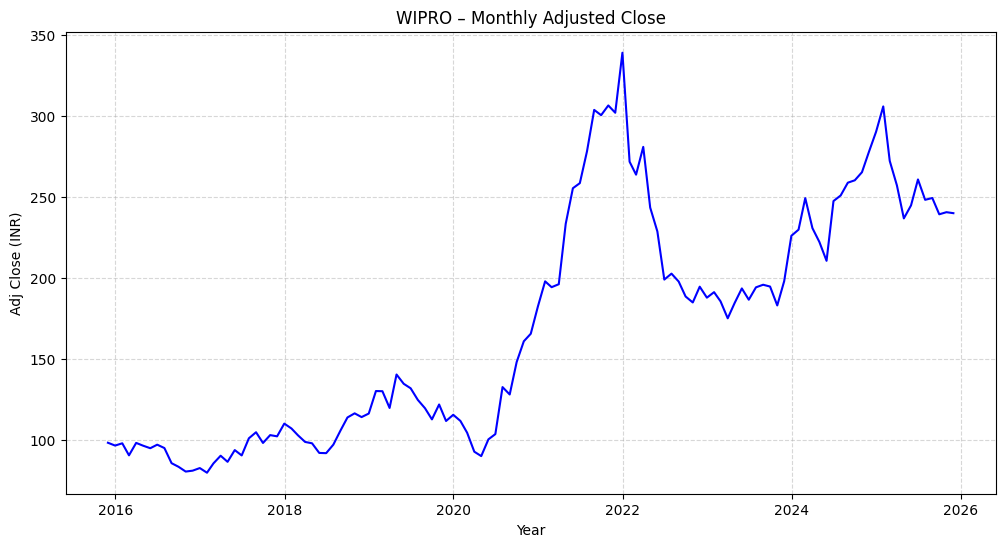

In [20]:
# --- Plot Monthly Adjusted Close Price for Wipro ---
plt.figure(figsize=(12, 6))  # Set chart size (width x height)

# Plot the last adjusted closing price for each month
plt.plot(df["monthly_adj_close"], color='blue')  # Use blue for Wipro

# Add chart title and labels for clarity
plt.title("WIPRO – Monthly Adjusted Close")  # Title of the graph
plt.xlabel("Year")                            # X-axis shows years
plt.ylabel("Adj Close (INR)")                 # Y-axis shows price in INR

# Add grid lines for better readability
plt.grid(True, linestyle="--", alpha=0.5)

# Show the chart
plt.show()


### Wipro – Monthly Adjusted Close  
Wipro’s stock price showed steady growth from 2016 to 2024.  
After reaching a peak, it slightly declined but stayed above earlier levels.


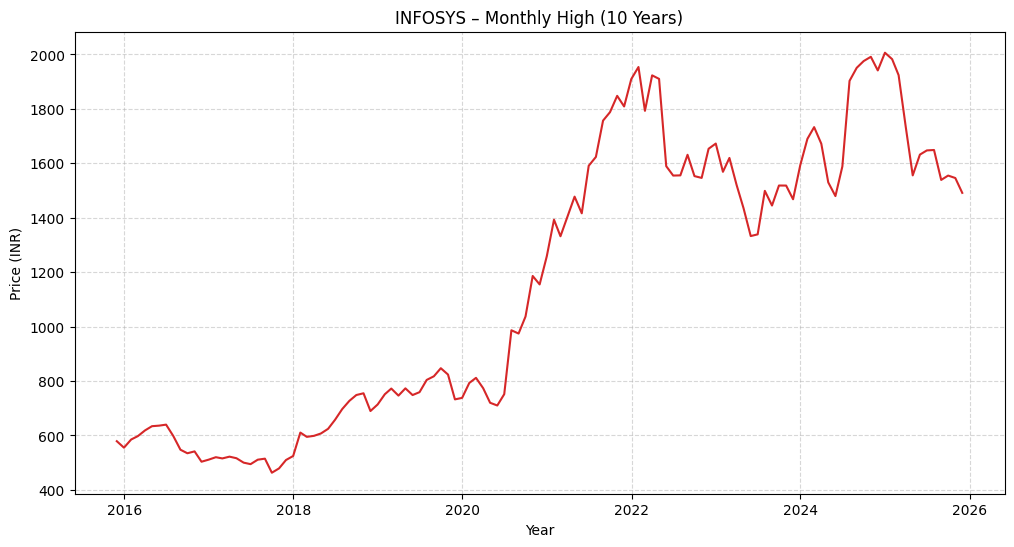

In [21]:
# Select company
name = "INFOSYS"
df = resampled_data[name]

# --- Plot Monthly High Prices for Infosys ---
plt.figure(figsize=(12, 6))  # Set chart size

# Plot the highest stock price each month
plt.plot(df["monthly_high"], color=COMPANY_COLORS[name])

# Add title and axis labels
plt.title("INFOSYS – Monthly High (10 Years)")  # Chart title
plt.xlabel("Year")                              # X-axis: Years
plt.ylabel("Price (INR)")                       # Y-axis: Price in INR

# Add grid lines for better readability
plt.grid(True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()

### Infosys – Monthly High (10 Years)  
Infosys shows a strong upward trend from 2018 to 2022.  
After 2022, the prices stayed high but showed some ups and downs.


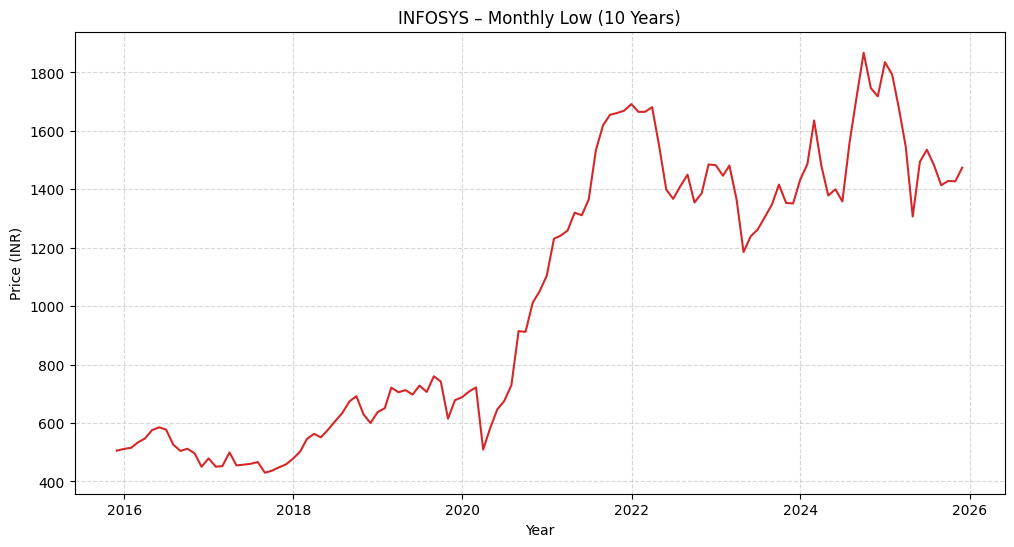

In [22]:
# Set the figure size for better visualization
plt.figure(figsize=(12,6))

# Plot the monthly lowest prices of INFOSYS
plt.plot(df["monthly_low"], color=COMPANY_COLORS[name])

# Add a title to the graph
plt.title("INFOSYS – Monthly Low (10 Years)")

# Label the X and Y axes
plt.xlabel("Year")
plt.ylabel("Price (INR)")

# Add light grid lines for better readability
plt.grid(True, linestyle="--", alpha=0.5)

# Display the plot
plt.show()

###  Infosys – Monthly Low (10 Years)  
Infosys stock price rose steadily after 2018, showing major growth by 2021.  
Post-2022, the prices fluctuated but stayed above earlier lows.


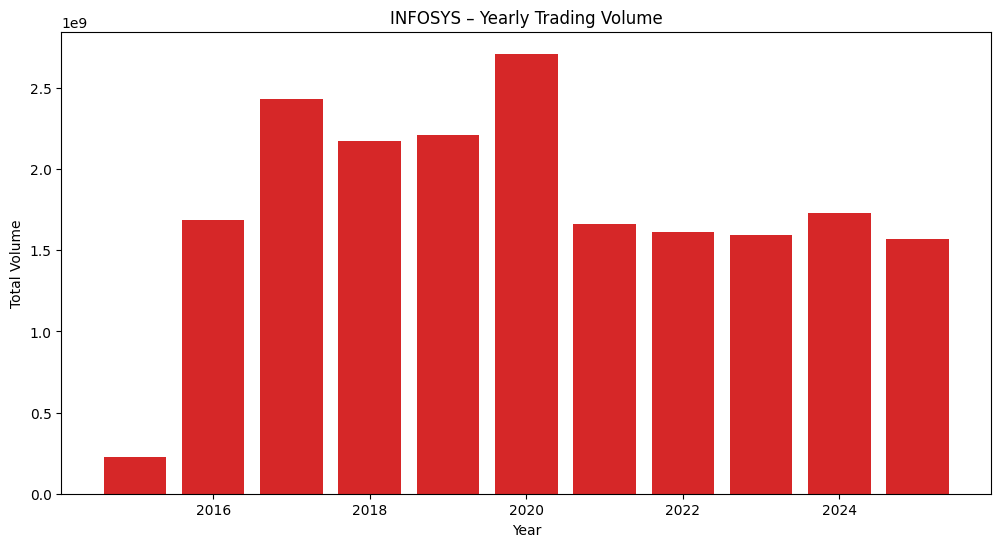

In [23]:
# Set the figure size for a clear view
plt.figure(figsize=(12,6))

# Extract only the year from the index (for the x-axis)
years = [d.year for d in df["yearly_volume"].index]

# Create a bar chart showing total trading volume per year
plt.bar(years, df["yearly_volume"].values, color=COMPANY_COLORS[name])

# Add a title to describe the chart
plt.title("INFOSYS – Yearly Trading Volume")

# Label the X and Y axes
plt.xlabel("Year")
plt.ylabel("Total Volume")

# Display the chart
plt.show()

###  Infosys – Yearly Trading Volume  
Infosys had the highest trading activity in 2020 during the market boom.  
After that, the volume remained stable with minor yearly variations.


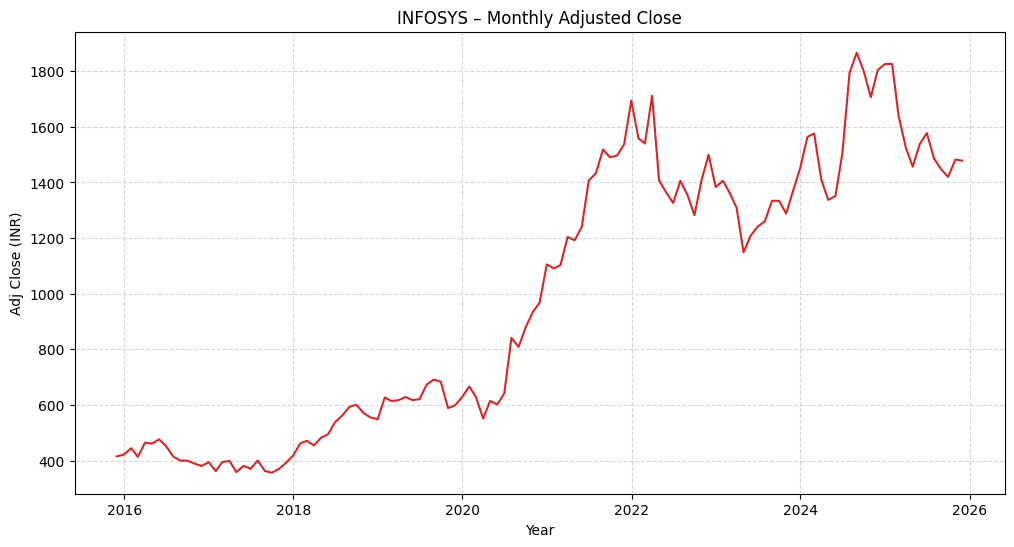

In [24]:
# Set the figure size for better visibility
plt.figure(figsize=(12,6))

# Plot the monthly adjusted close price for Infosys
plt.plot(df["monthly_adj_close"], color=COMPANY_COLORS[name])

# Add a title to the chart
plt.title("INFOSYS – Monthly Adjusted Close")

# Label the X and Y axes
plt.xlabel("Year")
plt.ylabel("Adj Close (INR)")

# Add light grid lines for easier reading
plt.grid(True, linestyle="--", alpha=0.5)

# Display the plot
plt.show()

###  Infosys – Monthly Adjusted Close (10 Years)
Infosys’ adjusted close price shows a steady upward trend from 2016 to 2021,  
peaking around early 2022 before moderate corrections.  
Overall, the stock demonstrates long-term growth with short-term volatility.


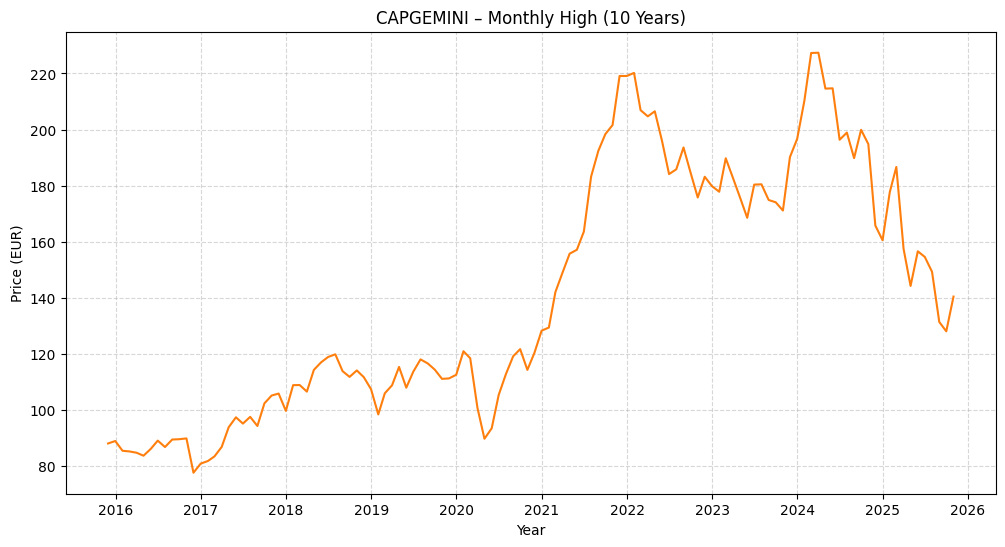

In [25]:
# Select the company name
name = "CAPGEMINI"

# Get the resampled data for Capgemini
df = resampled_data[name]

# Set the figure size for clear visualization
plt.figure(figsize=(12,6))

# Plot the monthly high prices for Capgemini
plt.plot(df["monthly_high"], color=COMPANY_COLORS[name])

# Add a descriptive title to the chart
plt.title("CAPGEMINI – Monthly High (10 Years)")

# Label the X and Y axes
plt.xlabel("Year")
plt.ylabel("Price (EUR)")

# Add grid lines to make the chart easier to read
plt.grid(True, linestyle="--", alpha=0.5)

# Display the plot
plt.show()

###  Capgemini – Monthly High (10 Years)
Capgemini’s stock showed steady growth from 2016 to 2021,  
reaching its peak around 2022 before facing several corrections.  
Despite fluctuations, it maintains a strong long-term upward performance.


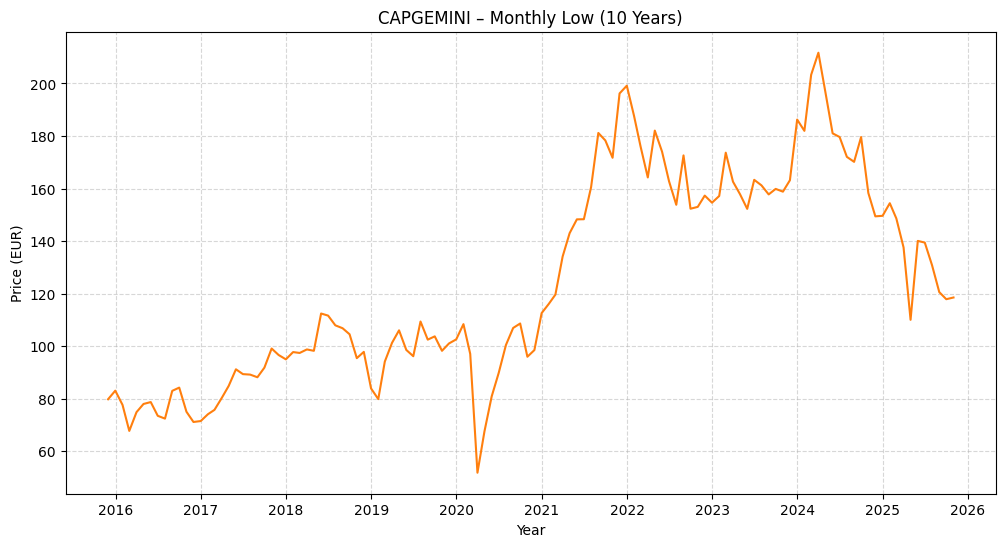

In [26]:
# Set the figure size for better visualization
plt.figure(figsize=(12,6))

# Plot the monthly low prices for Capgemini
plt.plot(df["monthly_low"], color=COMPANY_COLORS[name])

# Add a clear title to describe the chart
plt.title("CAPGEMINI – Monthly Low (10 Years)")

# Label the X and Y axes
plt.xlabel("Year")
plt.ylabel("Price (EUR)")

# Add grid lines for easier reading
plt.grid(True, linestyle="--", alpha=0.5)

# Display the plot
plt.show()

###  Capgemini – Monthly Low (10 Years)
The lowest prices show steady growth till 2021,  
followed by big drops in 2020 and 2025 due to market changes.  
Overall, the long-term trend remains positive despite short-term dips.


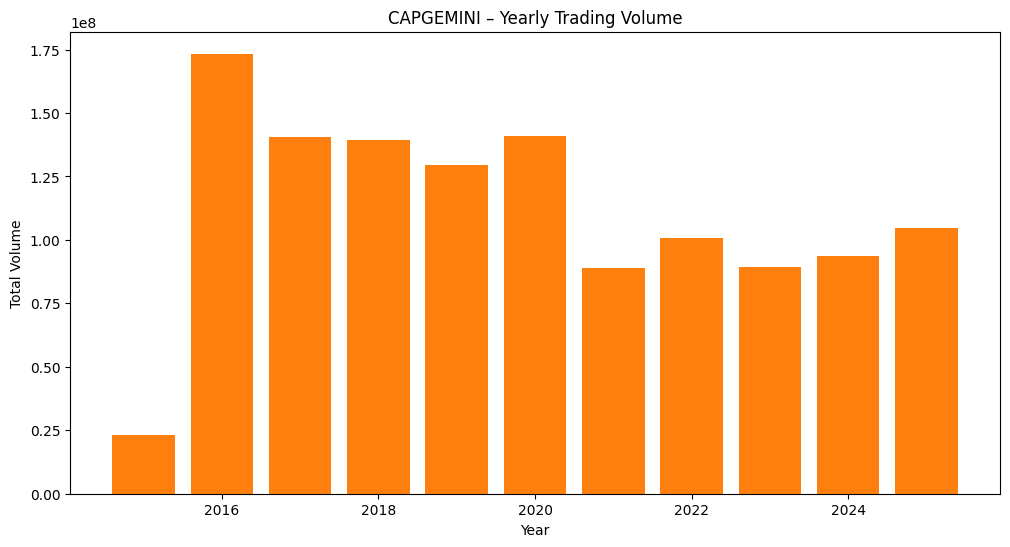

In [27]:
# Set the figure size for better visualization
plt.figure(figsize=(12,6))

# Extract the year values from the yearly volume index
years = [d.year for d in df["yearly_volume"].index]

# Create a bar chart showing yearly trading volume
plt.bar(years, df["yearly_volume"].values, color=COMPANY_COLORS[name])

# Add a title to describe the chart
plt.title("CAPGEMINI – Yearly Trading Volume")

# Label the X and Y axes
plt.xlabel("Year")
plt.ylabel("Total Volume")

# Display the final chart
plt.show()

###  Capgemini – Yearly Trading Volume
Trading activity was highest around 2016 and declined after 2020.  
In recent years, the volume has been more stable,  
showing steady investor interest in the stock.


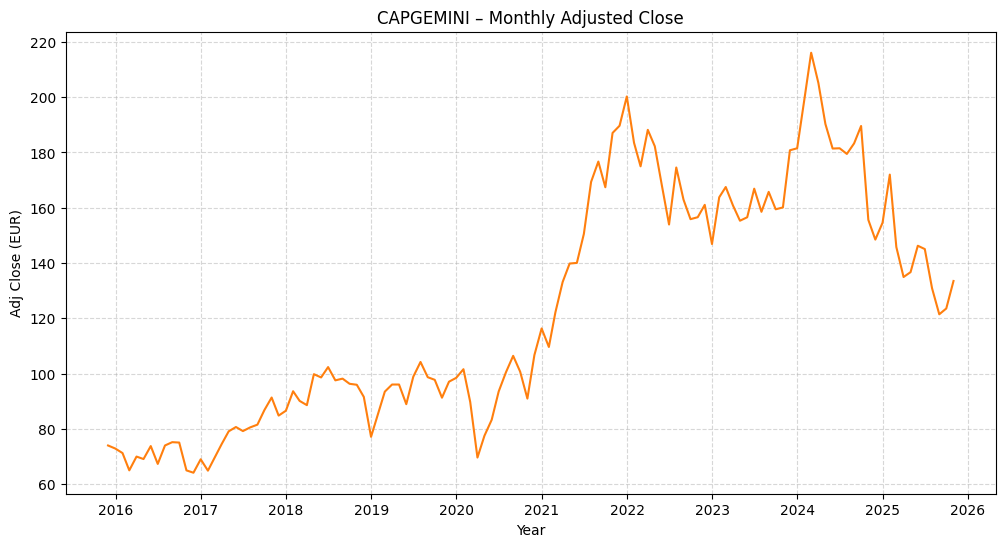

In [28]:
# Set the figure size to make the plot large and clear
plt.figure(figsize=(12,6))

# Plot the monthly adjusted closing prices for Capgemini
plt.plot(df["monthly_adj_close"], color=COMPANY_COLORS[name])

# Add a title to explain what the chart shows
plt.title("CAPGEMINI – Monthly Adjusted Close")

# Label the X and Y axes
plt.xlabel("Year")
plt.ylabel("Adj Close (EUR)")

# Add a light grid to make the chart easier to read
plt.grid(True, linestyle="--", alpha=0.5)

# Show the final plot
plt.show()


#### BIVARIATE COMPARISON ANALYSIS


**Monthly High Price Comparison (TCS vs Infosys)**

TCS consistently achieves higher monthly highs than Infosys, indicating stronger price momentum and investor confidence over time.
Infosys follows a steady upward trend but remains below TCS levels, reflecting competitive yet comparatively moderate price performance in the IT sector.

**TCS vs** **Infosys**

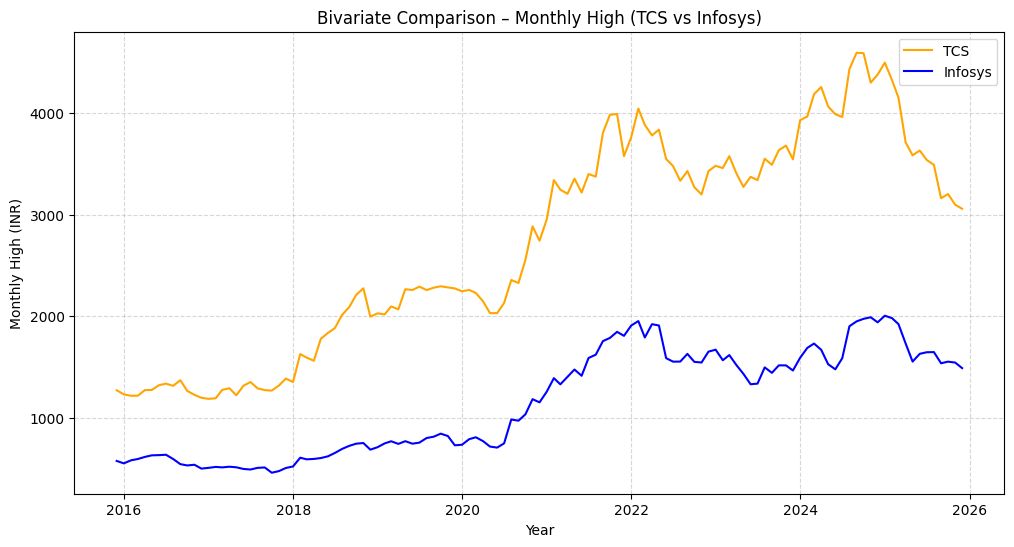

In [41]:
#  Use the correct key for Infosys (replace INFOSYS with whatever you see in output)
bivar_df = pd.concat(
    {
        "TCS": resampled_data["TCS"]["monthly_high"],
        "INFOSYS": resampled_data["INFOSYS"]["monthly_high"]   # <-- change if needed based on above output
    },
    axis=1
)

#  Plot
plt.figure(figsize=(12, 6))
plt.plot(bivar_df.index, bivar_df["TCS"], label="TCS", color="orange")
plt.plot(bivar_df.index, bivar_df["INFOSYS"], label="Infosys", color="blue")

plt.title("Bivariate Comparison – Monthly High (TCS vs Infosys)")
plt.xlabel("Year")
plt.ylabel("Monthly High (INR)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


**Monthly High Price Comparison (WIPRO vs Capgemini)**

Wipro generally shows stronger monthly high price performance compared to Capgemini, reflecting consistent investor confidence in the Indian IT market.
Capgemini exhibits stable but comparatively lower highs, indicating steady global IT market participation with less volatility.

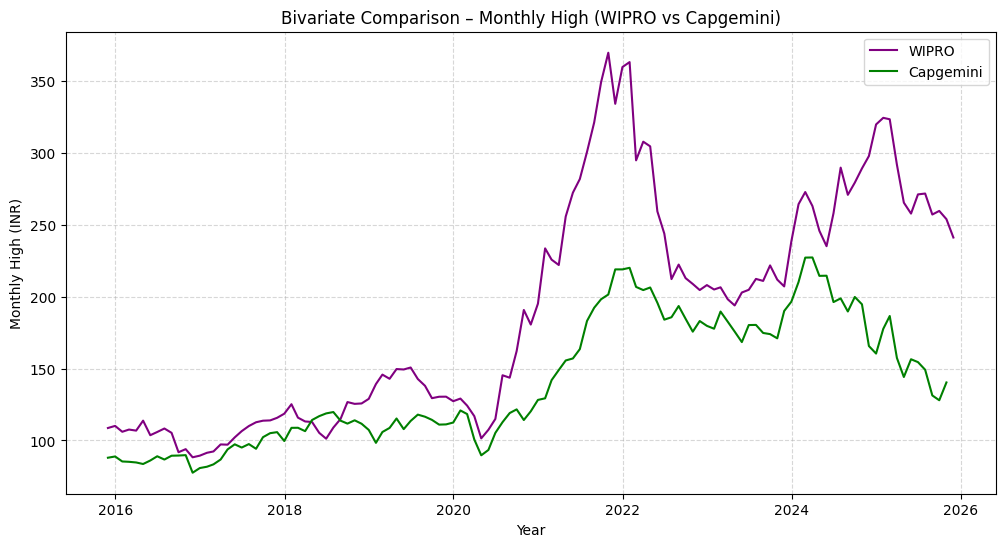

In [43]:
#  Replace CAPGEMINI with the correct key from the above output
bivar_df = pd.concat(
    {
        "WIPRO": resampled_data["WIPRO"]["monthly_high"],
        "CAPGEMINI": resampled_data["CAPGEMINI"]["monthly_high"]  # <-- change key if needed
    },
    axis=1
)

#  Plot chart
plt.figure(figsize=(12, 6))
plt.plot(bivar_df.index, bivar_df["WIPRO"], label="WIPRO", color="purple")
plt.plot(bivar_df.index, bivar_df["CAPGEMINI"], label="Capgemini", color="green")

plt.title("Bivariate Comparison – Monthly High (WIPRO vs Capgemini)")
plt.xlabel("Year")
plt.ylabel("Monthly High (INR)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


**Yearly Total Volume Comparison (TCS vs Infosys)**

TCS consistently records higher trading volumes than Infosys, indicating stronger market participation and liquidity.
Infosys shows steady but relatively lower volume trends, reflecting stable investor interest within the tech sector.

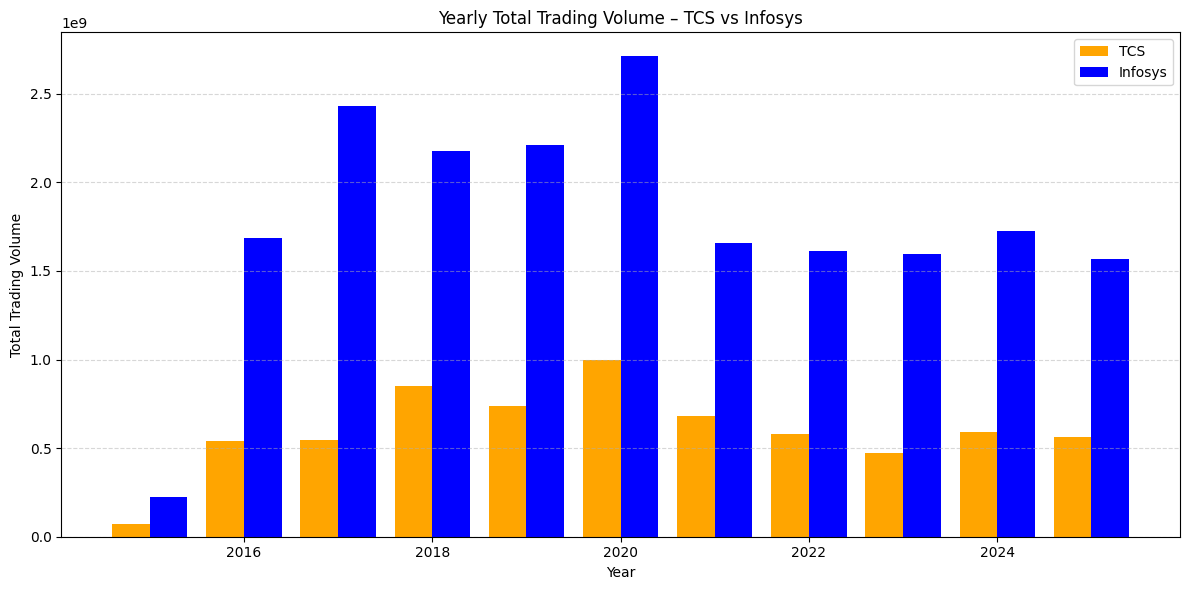

In [45]:
#  Replace "INFOSYS" below with the correct key if needed (e.g., "INFY")
yearly_volume = pd.DataFrame({
    "TCS": resampled_data["TCS"]["yearly_volume"],
    "INFOSYS": resampled_data["INFOSYS"]["yearly_volume"]
})

plt.figure(figsize=(12, 6))
plt.bar(yearly_volume.index.year - 0.2, yearly_volume["TCS"], width=0.4, color="orange", label="TCS")
plt.bar(yearly_volume.index.year + 0.2, yearly_volume["INFOSYS"], width=0.4, color="blue", label="Infosys")

plt.title("Yearly Total Trading Volume – TCS vs Infosys")
plt.xlabel("Year")
plt.ylabel("Total Trading Volume")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


**Yearly Total Volume Comparison (WIPRO vs Capgemini)**

Wipro shows consistently higher trading volume than Capgemini, indicating stronger liquidity and investor participation in the Indian market.
Capgemini maintains comparatively lower but steady volumes, reflecting its global trading pattern and stable investor interest.

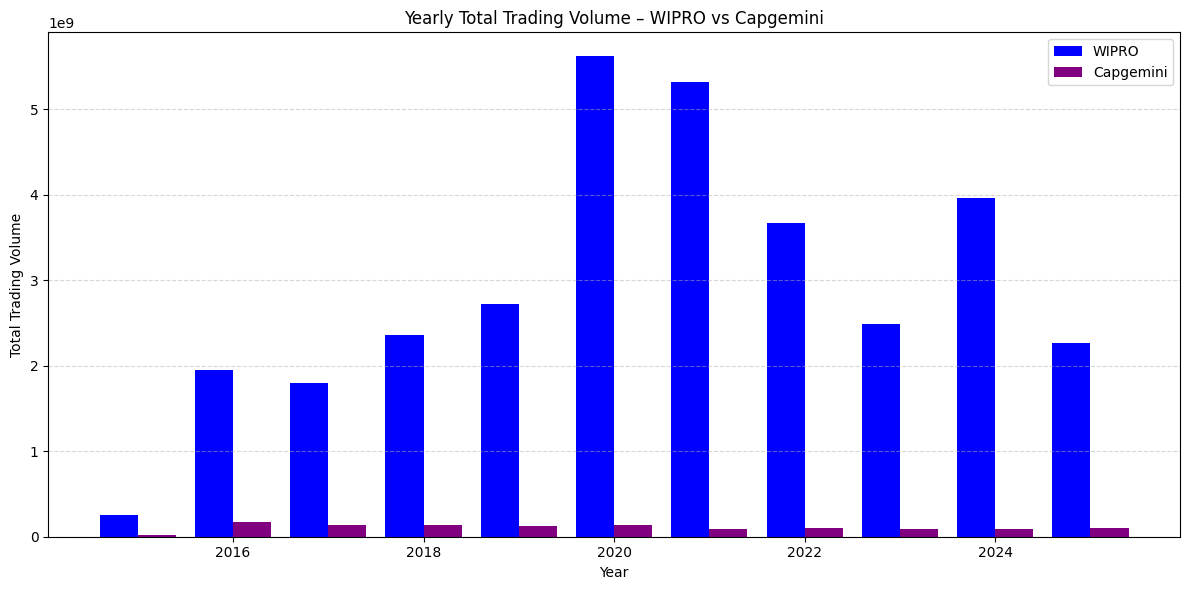

In [47]:
# Replace "CAPGEMINI" below if your key is different (e.g., "CAPGEMINI.PA")
yearly_volume_wc = pd.DataFrame({
    "WIPRO": resampled_data["WIPRO"]["yearly_volume"],
    "CAPGEMINI": resampled_data["CAPGEMINI"]["yearly_volume"]
})

plt.figure(figsize=(12, 6))
plt.bar(yearly_volume_wc.index.year - 0.2, yearly_volume_wc["WIPRO"], width=0.4, color="blue", label="WIPRO")
plt.bar(yearly_volume_wc.index.year + 0.2, yearly_volume_wc["CAPGEMINI"], width=0.4, color="purple", label="Capgemini")

plt.title("Yearly Total Trading Volume – WIPRO vs Capgemini")
plt.xlabel("Year")
plt.ylabel("Total Trading Volume")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### Comparison – Yearly Total Volume (Capgemini vs Infosys)
Trading volume peaked around 2020–2021 for both companies.  
Infosys shows consistently higher trading activity,  
indicating stronger investor participatio


**MULTIVARIATE COMPARISON ANALYSIS**

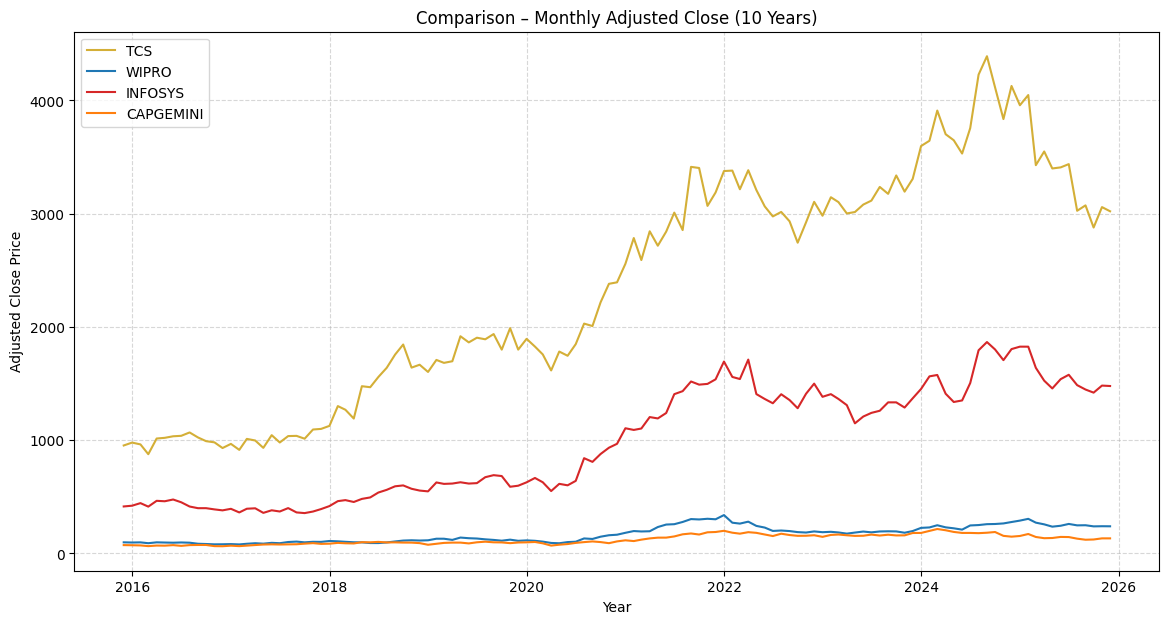

In [33]:
#  Combine monthly adjusted close data from all companies into one DataFrame
prices_df = pd.concat(
    {name: data["monthly_adj_close"] for name, data in resampled_data.items()}, axis=1
)

# Remove multi-level column names (keep only company names)
prices_df.columns = prices_df.columns.get_level_values(0)

# Sort by date, forward-fill missing values, and drop empty rows
prices_df = prices_df.sort_index().ffill().dropna(how="all")

# Create a larger figure for better visibility
plt.figure(figsize=(14,7))

# Plot each company’s monthly adjusted close line
for col in prices_df.columns:
    plt.plot(prices_df.index, prices_df[col], label=col, linewidth=1.5, color=COMPANY_COLORS[col])

# Add a title and axis labels
plt.title("Comparison – Monthly Adjusted Close (10 Years)")
plt.xlabel("Year")
plt.ylabel("Adjusted Close Price")

# Add legend to identify each company
plt.legend()

# Add light grid lines for clarity
plt.grid(True, linestyle="--", alpha=0.5)

# Display the final chart
plt.show()

### Comparison – Monthly Adjusted Close (10 Years)
Among TCS, Wipro, Infosys, and Capgemini, TCS leads with the strongest growth.  
Infosys shows consistent progress, while Wipro and Capgemini  
maintain slower but steady upward trends.


<Figure size 1400x700 with 0 Axes>

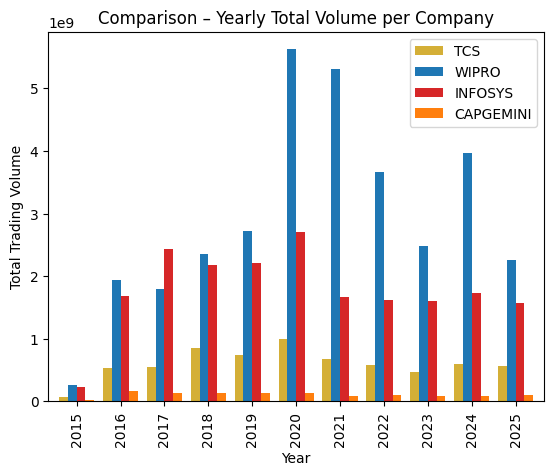

In [34]:
#  Combine yearly trading volume data from all companies into one DataFrame
yearvol_df = pd.concat(
    {name: data["yearly_volume"] for name, data in resampled_data.items()}, axis=1
)

# Simplify multi-level column names (keep only company names)
yearvol_df.columns = yearvol_df.columns.get_level_values(0)

# Convert the index (which is in datetime format) to just the year (integer)
yearvol_df.index = [d.year for d in yearvol_df.index]

# Set figure size for better readability
plt.figure(figsize=(14,7))

#  Create a bar plot comparing yearly trading volumes of all companies
yearvol_df.plot(
    kind="bar",
    color=[COMPANY_COLORS[c] for c in yearvol_df.columns],  # Use consistent company colors
    width=0.8
)

# Add title and axis labels
plt.title("Comparison – Yearly Total Volume per Company")
plt.xlabel("Year")
plt.ylabel("Total Trading Volume")

# Display the chart
plt.show()

###  Comparison – Yearly Total Volume per Company
Wipro and Infosys recorded the highest yearly trading volumes,  
indicating stronger market activity.  
Capgemini and TCS showed moderate yet stable participation.


#### DESCRIPTIVE STATISTICAL SUMMARY


In [35]:
# Display key statistics (like mean, min, max) for each company's stock data
for name, df in data_dict.items():
    # Print company name
    print(f"\n=====  {name} Statistical Summary =====")

    # Show statistical details such as:
    # count = number of entries,
    # mean = average value,
    # std = standard deviation,
    # min = lowest value,
    # 25%, 50%, 75% = quartiles,
    # max = highest value
    print(df.describe())


=====  TCS Statistical Summary =====
              Open         High          Low        Close    Adj Close  \
count  2469.000000  2469.000000  2469.000000  2469.000000  2469.000000   
mean   2592.138071  2616.730606  2566.421654  2591.172154  2355.585300   
std    1013.361962  1021.232901  1005.365688  1012.781554  1029.609648   
min    1058.449951  1070.000000  1025.949951  1050.574951   859.461609   
25%    1709.949951  1743.250000  1675.050049  1705.449951  1450.864746   
50%    2699.000000  2730.000000  2669.050049  2705.800049  2413.227051   
75%    3434.000000  3460.000000  3407.000000  3436.300049  3209.475098   
max    4576.000000  4592.250000  4512.000000  4553.750000  4389.965820   

             Volume  
count  2.469000e+03  
mean   2.688012e+06  
std    2.389106e+06  
min    0.000000e+00  
25%    1.655427e+06  
50%    2.245977e+06  
75%    3.106660e+06  
max    8.806715e+07  

=====  WIPRO Statistical Summary =====
              Open         High          Low        Close


####TEXTUAL INSIGHTS & OBSERVATIONS


In [36]:
#  Print key insights from the stock market analysis (2015–2025)
print("\n Key Insights from Stock Market Analysis (2015–2025):\n")

# --- TCS Insights ---
print(" TCS:")
print(" - Shows consistent long-term growth with relatively low volatility.")
print(" - Maintains stability even during market corrections after 2020.\n")

# --- WIPRO & INFOSYS Insights ---
print(" WIPRO & INFOSYS:")
print(" - Move in a similar pattern with common highs and lows.")
print(" - Had strong peaks during the 2021 technology boom, showing high investor confidence.\n")

# --- CAPGEMINI Insights ---
print(" CAPGEMINI:")
print(" - Traded in the European market, so prices are based in Euros.")
print(" - Shows a steady upward trend and recovery after 2020 market drop.\n")

# --- Trading Volume Insights ---
print(" Trading Volume Insights:")
print(" - Volume increased during major global events (like COVID-19 and 2021 bull run).")
print(" - This shows higher investor activity and market speculation in those periods.\n")


 Key Insights from Stock Market Analysis (2015–2025):

 TCS:
 - Shows consistent long-term growth with relatively low volatility.
 - Maintains stability even during market corrections after 2020.

 WIPRO & INFOSYS:
 - Move in a similar pattern with common highs and lows.
 - Had strong peaks during the 2021 technology boom, showing high investor confidence.

 CAPGEMINI:
 - Traded in the European market, so prices are based in Euros.
 - Shows a steady upward trend and recovery after 2020 market drop.

 Trading Volume Insights:
 - Volume increased during major global events (like COVID-19 and 2021 bull run).
 - This shows higher investor activity and market speculation in those periods.

